In [1]:
%matplotlib inline

import sys
sys.path.append("../")
import scvi
from smFISHxscRNA.dataset import CortexDataset, SmfishDataset
from smFISHxscRNA.inference import VariationalInferenceFish
from smFISHxscRNA.models import VAEF
from smFISHxscRNA.metrics.clustering import get_data, get_common_t_sne, entropy_batch_mixing, get_estimated_values
from smFISHxscRNA.metrics.visualisation import show_cell_types, show_mixing, compare_cell_types, show_gene_exp, show_spatial_expression
from smFISHxscRNA.metrics.classification import cluster_accuracy_nn, cluster_accuracy_svc
from smFISHxscRNA.metrics.imputation import plot_correlation, proximity_imputation, compute_metrics, get_index, plot_imputation
import numpy as np
from smFISHxscRNA.train import train_FISHVAE_jointly


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
genes_to_discard = ['gad2']
gene_dataset_fish = SmfishDataset()
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
indexes_to_keep = np.arange(len(gene_names))
indexes_to_keep = np.delete(indexes_to_keep, genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


In [139]:
gene_dataset_seq = CortexDataset(genes_fish=gene_dataset_fish.gene_names, 
                                 genes_to_keep=["mog", "sst", "gja1", "ctss", "ndnf"], additional_genes=200)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


In [4]:
print(gene_dataset_seq.gene_names)
print(gene_dataset_fish.gene_names)

['GAD2' 'SLC32A1' 'CRHBP' 'CNR1' 'VIP' 'CPNE5' 'PTHLH' 'CRH' 'TBR1'
 'LAMP5' 'RORB' 'SYT6' 'KCNIP2' 'ALDOC' 'GFAP' 'SERPINF1' 'MFGE8' 'SOX10'
 'PLP1' 'PDGFRA' 'BMP4' 'ITPR2' 'TMEM2' 'CTPS' 'ANLN' 'MRC1' 'HEXB' 'TTR'
 'FOXJ1' 'VTN' 'FLT1' 'APLN' 'ACTA2' 'HTR3A' 'ALDOA' 'SYT1' 'NDNF' 'NPY'
 'SST' 'STMN3' 'NDUFA4' 'MDH1' 'SLC25A4' 'TUBB2A' 'TUBA1A' 'CST3'
 'CAMK2N1' 'SLC1A2' 'PCP4' 'SNAP25' 'CALM1' 'PPIA' 'SCG5' 'SNHG11' 'MEG3'
 'TTC3' 'HSP90AA1' 'SPARCL1' 'HSP90AB1' 'SNCA' 'ACTG1' 'ACTB' 'GPM6A'
 'DYNLL1' 'GSTP1' 'CHN1' 'CALM2' 'FTH1' 'TMSB4X' 'ATP1B1' 'RTN1' 'APP'
 'MAP1B' 'CPE' 'NRGN' 'PPP3CA' 'GRIA2' 'ATP2B1' 'PRKCB' 'KCTD12' 'MBP'
 'CNP' 'CD81' 'MOG' 'MALAT1' 'ENPP2' 'PTGDS' 'UGT8A' 'MAG' 'MAL' 'CAR2'
 'DBI' 'TRF' 'APOD' 'CTSS' 'HBB-B2' 'HBA-A2_LOC2' 'HBA-A2_LOC1' 'HBB-BS'
 'ATP1A2' 'GJA1' 'APOE']
['Gad2' 'Slc32a1' 'Crhbp' 'Cnr1' 'Vip' 'Cpne5' 'Pthlh' 'Crh' 'Tbr1'
 'Lamp5' 'Rorb' 'Syt6' 'Kcnip2' 'Aldoc' 'Gfap' 'Serpinf1' 'Mfge8' 'Sox10'
 'Plp1' 'Pdgfra' 'Bmp4' 'Itpr2' 'Tmem2' 'Ctps' 

In [4]:
# Creating dataloaders
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
use_cuda = False
gene_dataset = gene_dataset_seq
tt_split =0.9
example_indices = np.random.permutation(len(gene_dataset))
tt_split = int(tt_split * len(gene_dataset))  # 90%/10% train/test split
data_loader_seq = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                               sampler=SubsetRandomSampler(example_indices[:tt_split]),
                               collate_fn=gene_dataset.collate_fn)


gene_dataset = gene_dataset_fish
tt_split =0.9
example_indices = np.random.permutation(len(gene_dataset))
tt_split = int(tt_split * len(gene_dataset))  # 90%/10% train/test split
data_loader_fish = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                               sampler=SubsetRandomSampler(example_indices[:tt_split]),
                               collate_fn=gene_dataset.collate_fn)

In [164]:
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=2, n_latent=8,
           n_layers=2, n_hidden=256, reconstruction_loss='nb', dropout_rate=0.3, n_labels=7, n_batch=0, model_library=False)
infer = VariationalInferenceFish(vae, gene_dataset_seq, gene_dataset_fish, train_size=0.9, verbose=True, frequency=5, weight_decay=0.25)
infer.train(n_epochs=200, lr=0.001)
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']
# train_FISHVAE_jointly(vae, data_loader_seq, data_loader_fish, lr=0.01, n_epochs=200, weight_decay=0.25)


EPOCH [0/200]: 
LL for train_seq is : 914.2471
LL for test_seq is : 906.8129
LL for train_fish is : 228.7406
LL for test_fish is : 246.4409

EPOCH [5/200]: 
LL for train_seq is : 785.2416
LL for test_seq is : 776.0900
LL for train_fish is : 159.9927
LL for test_fish is : 162.8507

EPOCH [10/200]: 
LL for train_seq is : 678.5687
LL for test_seq is : 668.5156
LL for train_fish is : 130.6104
LL for test_fish is : 131.8438

EPOCH [15/200]: 
LL for train_seq is : 660.9141
LL for test_seq is : 650.9588
LL for train_fish is : 130.8311
LL for test_fish is : 132.2792

EPOCH [20/200]: 
LL for train_seq is : 657.2458
LL for test_seq is : 648.4806
LL for train_fish is : 127.2548
LL for test_fish is : 128.3132

EPOCH [25/200]: 
LL for train_seq is : 653.3847
LL for test_seq is : 643.9797
LL for train_fish is : 126.2790
LL for test_fish is : 128.6111

EPOCH [30/200]: 
LL for train_seq is : 647.0882
LL for test_seq is : 636.0175
LL for train_fish is : 122.6918
LL for test_fish is : 124.0289

EPOCH [

In [165]:
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']
# Getting data of interest
latent_seq, _, labels_seq, expected_frequencies_seq, values_seq = get_data(vae, data_loader_seq, mode="scRNA")
latent_fish, _, labels_fish, expected_frequencies_fish, values_fish, x_coords, y_coords = get_data(vae, data_loader_fish, mode="smFISH")

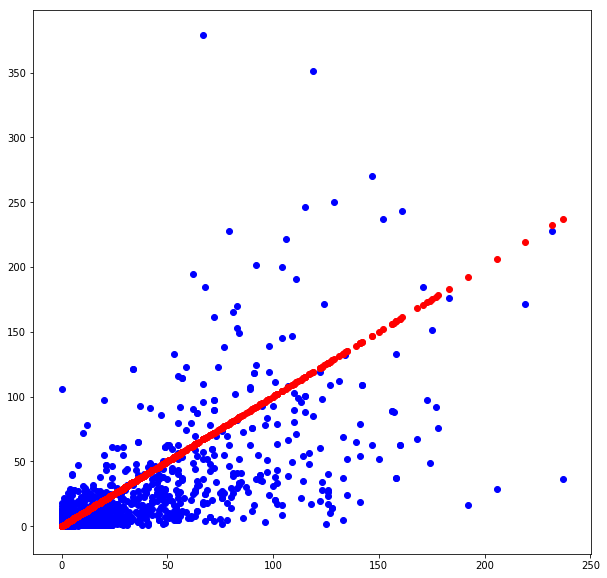

In [187]:
est_fish, real_fish = get_estimated_values(vae, data_loader_fish, mode="smFISH")
imputed = expected_frequencies_fish[:, 0] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
plot_correlation(values_fish[:, 0], imputed)

../smFISHxscRNA/metrics/imputation.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(y[:, np.newaxis], x)


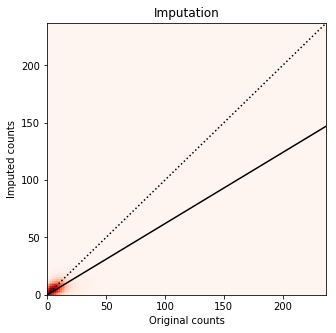

In [188]:
plot_imputation(imputed, values_fish[:, 0])

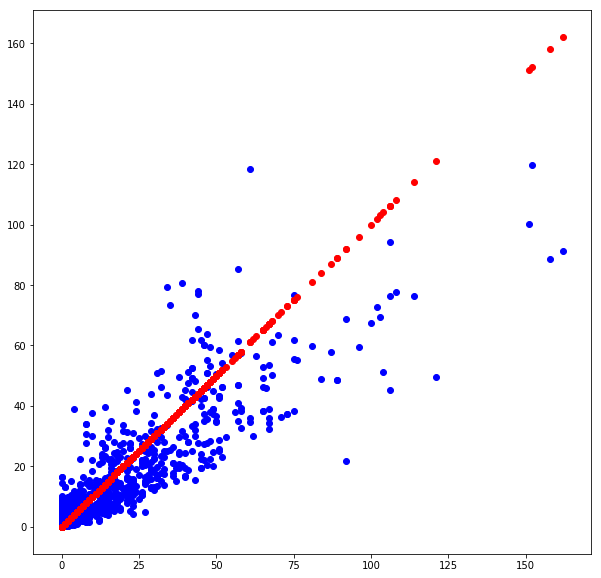

In [186]:
est_fish, real_fish = get_estimated_values(vae, data_loader_fish, mode="smFISH")

real_fish = real_fish[:, vae.indexes_to_keep]
% matplotlib inline
import matplotlib.pyplot as plt
plot_correlation(real_fish[:, 0], est_fish[:, 0])
plt.show()

In [169]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, 1:], gene_dataset_seq.X[:, :(len(gene_dataset_fish.gene_names)-1)]))
concatenated_matrix = np.log(1 + concatenated_matrix)
PCA_labels = gene_dataset_fish.labels.ravel()
PCA_labels_reg = gene_dataset_seq.labels.ravel()
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
latent_pca = pca.fit_transform(concatenated_matrix)
PCA_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]
PCA_values_seq = gene_dataset_seq.X
PCA_values_fish = gene_dataset_fish.X
PCA_labels_seq = gene_dataset_seq.labels
PCA_labels_fish = gene_dataset_fish.labels
print(PCA_values_seq.shape)
print(PCA_labels_seq.shape)

(2485, 228)
(2485, 1)


In [170]:
t_sne_seq, t_sne_fish, idx_t_sne_seq, idx_t_sne_fish = get_common_t_sne(latent_seq, latent_fish, n_samples=1000)


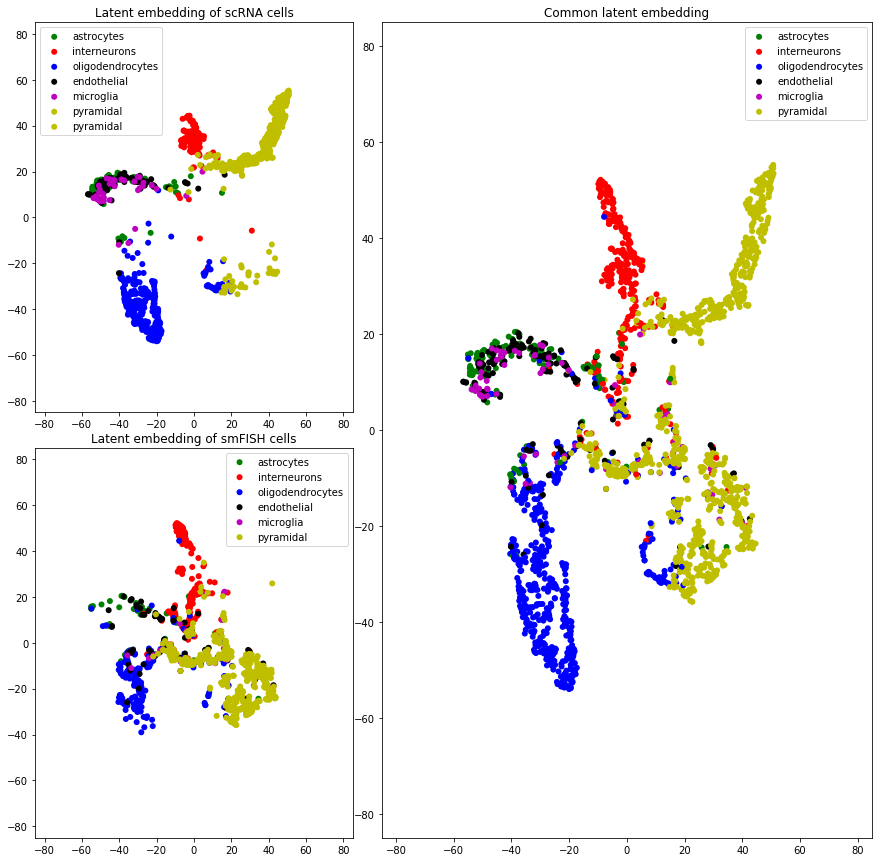

<Figure size 432x288 with 0 Axes>

In [171]:
show_cell_types(t_sne_seq, labels_seq[idx_t_sne_seq], t_sne_fish, labels_fish[idx_t_sne_fish])


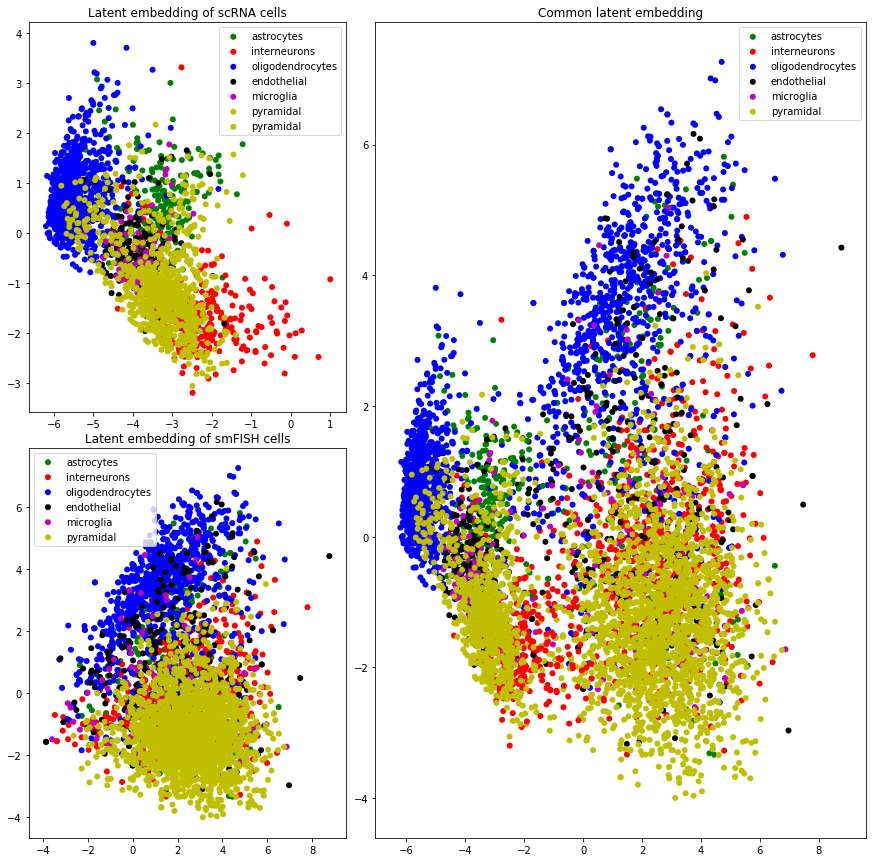

<Figure size 432x288 with 0 Axes>

In [172]:
show_cell_types(PCA_latent_seq[:, :2], PCA_labels_seq.ravel(), PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), x_lim=None)


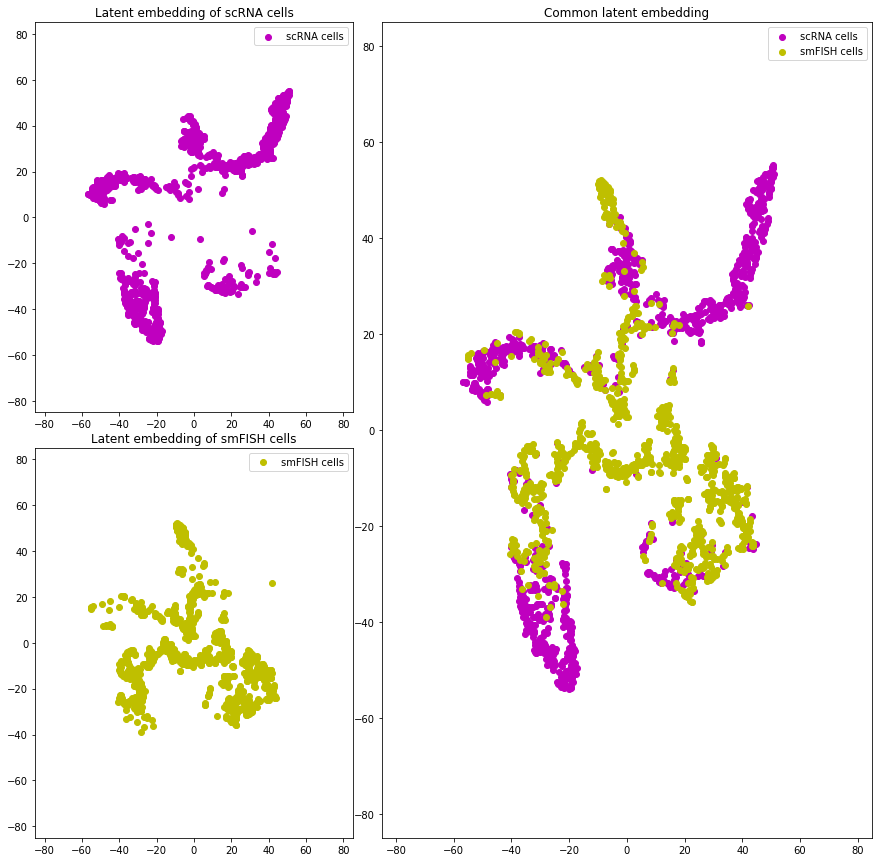

0.3953557951412088


<Figure size 432x288 with 0 Axes>

In [173]:
show_mixing(t_sne_seq, t_sne_fish)
print(entropy_batch_mixing(np.concatenate((t_sne_seq, t_sne_fish)),
                           batches=np.concatenate((np.zeros_like(idx_t_sne_seq),
                                                  np.ones_like(idx_t_sne_fish)))))

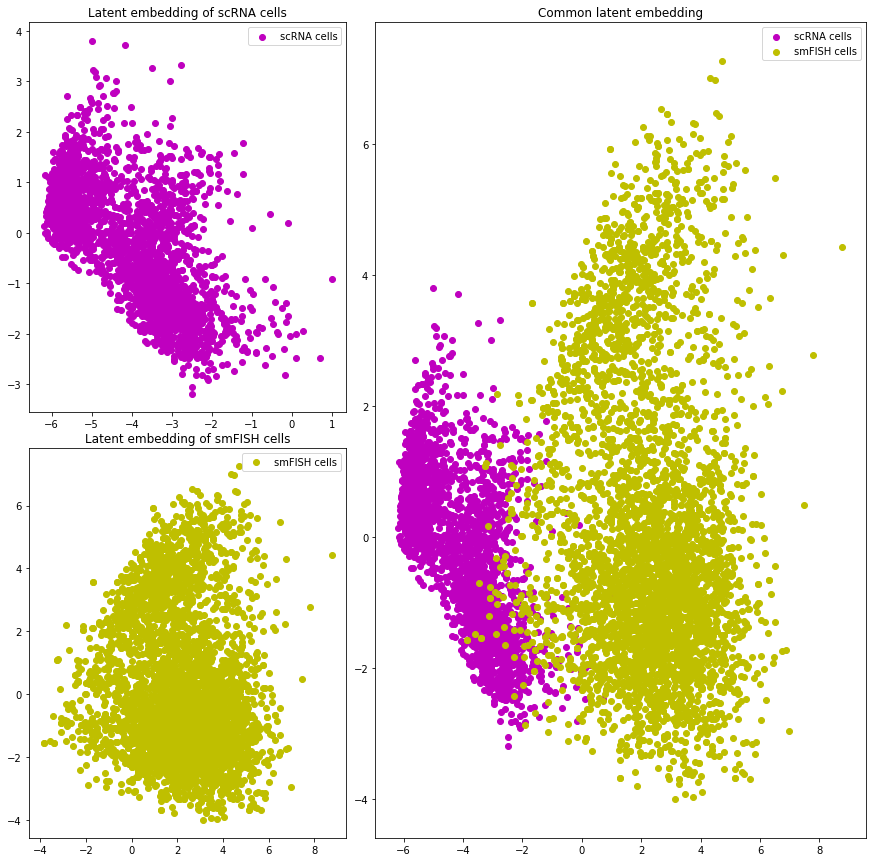

0.07890854942690337


<Figure size 432x288 with 0 Axes>

In [174]:
show_mixing(PCA_latent_seq[:, :2], PCA_latent_fish[:, :2], x_lim=None)
print(entropy_batch_mixing(np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2])),
                           batches=np.concatenate((np.zeros_like(PCA_latent_seq[:, :2]),
                                                  np.ones_like(PCA_latent_fish[:, :2])))))

In [183]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


def cluster_svc(frequencies1, label1, frequencies2):
    svc = SVC()
    parameters = {'kernel':('linear', 'rbf'), 'C': [1, 100], 'class_weight': ['balanced']}
    clf = GridSearchCV(svc, parameters)
    clf.fit(frequencies1, label1)
    inferred_labels = clf.predict(frequencies2)
    return inferred_labels


def cluster_accuracy_svc(frequencies1, label1, frequencies2, label2):
    inferred_labels = cluster_svc(frequencies1, label1, frequencies2)
    for label in range(inferred_labels.shape[0]):
        if inferred_labels[label] == 6:
            inferred_labels[label] = 5
    clustering_accuracy = np.mean(inferred_labels == label2)*100
    return clustering_accuracy, inferred_labels
accuracy_svc, inferred_labels_svc = cluster_accuracy_svc(expected_frequencies_seq, labels_seq, expected_frequencies_fish, labels_fish)


In [184]:
accuracy, inferred_labels = cluster_accuracy_nn(latent_seq, labels_seq, latent_fish, labels_fish, k=1)
# PCA_accuracy, PCA_inferred_labels = cluster_accuracy_nn(PCA_latent_seq, PCA_labels_seq.ravel(), PCA_latent_fish, PCA_labels_fish.ravel())


In [185]:
print(accuracy)
# print(PCA_accuracy)
print(accuracy_svc)

51.70610211706103
62.76463262764632


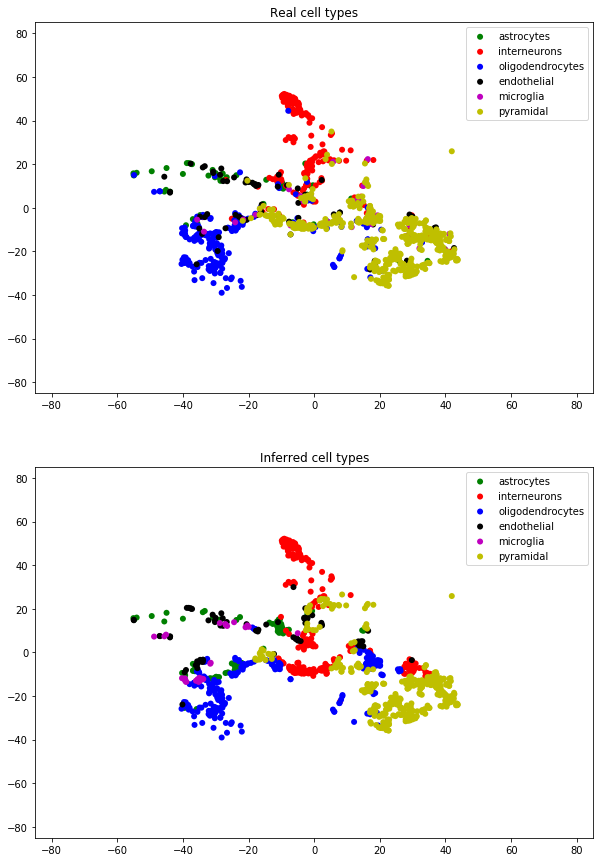

<Figure size 432x288 with 0 Axes>

In [178]:
compare_cell_types(t_sne_fish, labels_fish[idx_t_sne_fish], inferred_labels[idx_t_sne_fish])


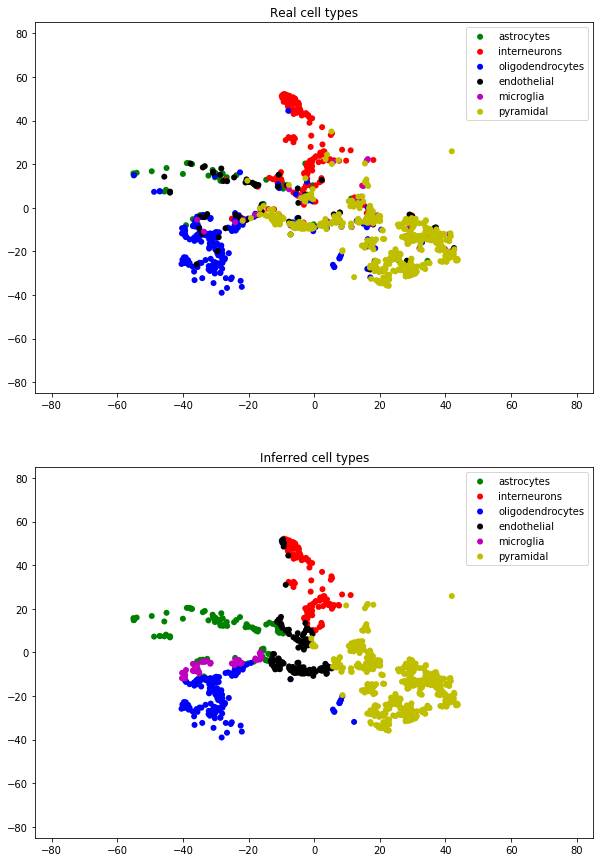

<Figure size 432x288 with 0 Axes>

In [179]:
compare_cell_types(t_sne_fish, labels_fish[idx_t_sne_fish], inferred_labels_svc[idx_t_sne_fish])


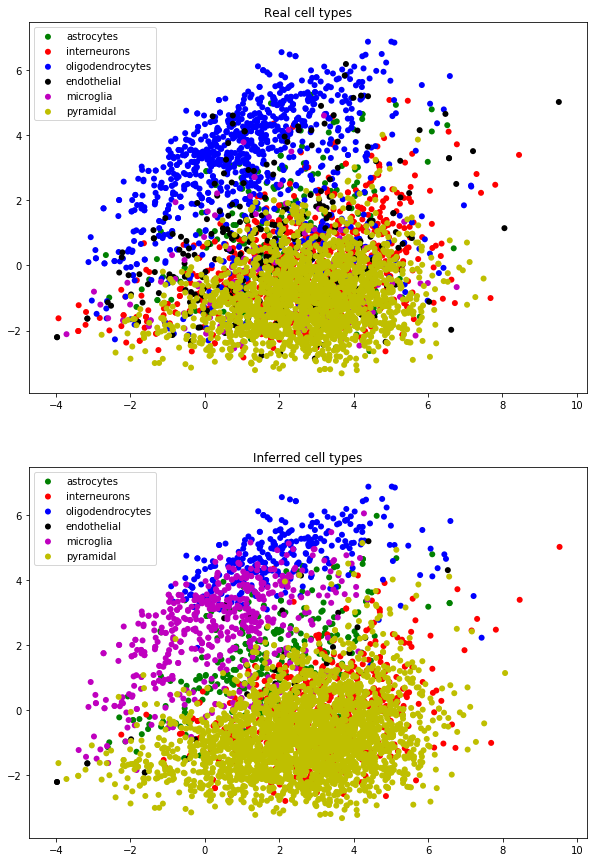

<Figure size 432x288 with 0 Axes>

In [20]:
compare_cell_types(PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), PCA_inferred_labels, x_lim=None)


[0.05824912 0.01868156 0.00875199 0.02721206 0.02221788 0.01693377
 0.00561612 0.00796632 0.08888242 0.13807128 0.04126934 0.02555801
 0.09782853 0.04375461 0.02240765 0.03013898 0.0276916  0.05494428
 0.03009831 0.01393215 0.00603538 0.01010394 0.01129426 0.03694493
 0.03077285 0.02885888 0.02271958 0.01255198 0.00871475 0.01273186
 0.00638178 0.01748691 0.01519694]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan inf inf nan
 nan nan nan inf inf inf inf inf inf nan nan nan nan inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf nan nan nan nan nan inf nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
(2704, 102)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: max must be larger than min in range parameter.

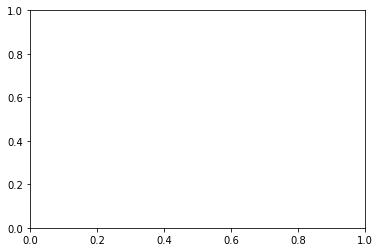

In [214]:
real_values_fish = values_fish / np.sum(values_fish, axis=1).reshape(-1, 1)
real_values_seq = values_seq / np.sum(values_seq[:, :33], axis=1).reshape(-1, 1)
print(np.mean(real_values_fish, axis=0))
print(np.mean(real_values_seq, axis=0))


print(real_values_seq.shape)
plt.hist(real_values_seq[:, idx_to_impute])
plt.hist(real_values_fish[:, 0])





In [173]:
# Getting more data
print(vae.indexes_to_keep)
#normed_expected_frequencies_seq = expected_frequencies_seq / np.sum(expected_frequencies_seq[:, :vae.indexes_to_keep],
#                                                                    axis=1).reshape(-1, 1)
normed_expected_frequencies_fish = expected_frequencies_fish / np.sum(expected_frequencies_fish[:, :vae.n_input_fish],
                                                                    axis=1).reshape(-1, 1)
idx_to_impute = get_index(gene_dataset_seq.gene_names, "gad2")
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")
proximity_imputed_values_fish = proximity_imputation(latent_seq, normed_expected_frequencies_seq[:, idx_to_impute],
                                                     latent_fish)

real_values_fish = values_fish / np.sum(values_fish, axis=1).reshape(-1, 1)

print(real_values_fish[2, :])
a = normed_expected_frequencies_fish[2, :] / np.sum(normed_expected_frequencies_fish[2, vae.indexes_to_keep] + normed_expected_frequencies_fish[2, idx_to_impute])
print(a[:33])


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Found idx 35 for gene gad2!
Found idx 100 for gene gja1!
Found idx 83 for gene mog!
Found idx 38 for gene sst!
[0.00746269 0.         0.         0.01492537 0.         0.
 0.         0.         0.13432837 0.         0.         0.00746269
 0.01492537 0.05223881 0.14925373 0.08955224 0.02985075 0.12686567
 0.         0.12686567 0.         0.         0.         0.
 0.02985075 0.03731343 0.04477612 0.05970149 0.         0.
 0.05223881 0.02238806 0.        ]
[0.00329475 0.01208085 0.00809909 0.01886306 0.02021015 0.00319264
 0.00525717 0.00863245 0.05836686 0.02306477 0.01383724 0.0125633
 0.02781946 0.07886399 0.05571291 0.03574664 0.07080066 0.03098314
 0.01592774 0.02436457 0.0079485  0.01117877 0.00750187 0.01426347
 0.02372697 0.02723346 0.02544487 0.01192842 0.00904084 0.02391875
 0.01979457 0.0192819  0.01617669]


In [191]:

print(imputed)

[[0.00292829 0.01089365 0.00713323 ... 0.08298688 0.01906639 0.08233086]
 [0.00439386 0.01567878 0.01058277 ... 0.44225064 0.10892568 0.5138118 ]
 [0.00439363 0.01611008 0.01080032 ... 0.41850144 0.10434476 0.48698407]
 ...
 [0.00357778 0.01283402 0.00891151 ... 0.5213489  0.12273884 0.6144172 ]
 [0.00543838 0.01179148 0.00821907 ... 0.06329305 0.01569888 0.0578638 ]
 [0.0051283  0.02050452 0.01050874 ... 0.07508671 0.01942006 0.07803975]]


0.81967545


../smFISHxscRNA/metrics/imputation.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(y[:, np.newaxis], x)


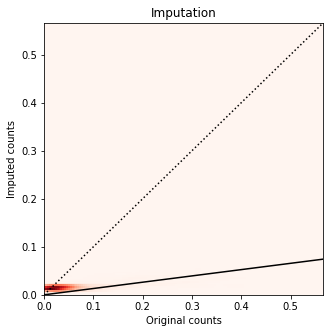

In [143]:
imputed = expected_frequencies_fish / (np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1) + normed_expected_frequencies_fish[:, idx_to_impute]).reshape(-1, 1)
#print(np.sum(imputed[0, :]))
print(np.sum(imputed[0, :33]))


real_values_fish = values_fish / np.sum(values_fish, axis=1).reshape(-1, 1)
plot_imputation(1.3 * imputed[:, idx_to_impute], real_values_fish[:, 0])



(array([  4.,  12.,  21.,  31.,  29.,  36.,  54.,  66.,  90., 131., 160.,
        170., 156., 193., 194., 205., 175., 157., 141., 133., 133., 120.,
        143., 112., 118., 116.,  89.,  79.,  75.,  58.,  65.,  45.,  35.,
         27.,  33.,  22.,  22.,  13.,  13.,  16.,  15.,  10.,   9.,  16.,
         16.,   6.,  11.,  10.,   7.,   8.,   6.,  15.,   7.,  12.,  12.,
          6.,  13.,   6.,   9.,   6.,  10.,   5.,  11.,   6.,   8.,   3.,
          7.,  15.,   4.,   6.,  15.,  13.,  10.,  10.,  13.,  15.,   4.,
          8.,  15.,  11.,   6.,  17.,   6.,  14.,  19.,  13.,   8.,   8.,
          3.,  13.,   3.,   3.,   3.,   5.,   3.,   1.,   1.,   0.,   2.,
          6.]),
 array([0.00307326, 0.00328092, 0.00348859, 0.00369626, 0.00390392,
        0.00411159, 0.00431926, 0.00452692, 0.00473459, 0.00494226,
        0.00514992, 0.00535759, 0.00556526, 0.00577292, 0.00598059,
        0.00618825, 0.00639592, 0.00660359, 0.00681125, 0.00701892,
        0.00722659, 0.00743425, 0.00764192, 0.

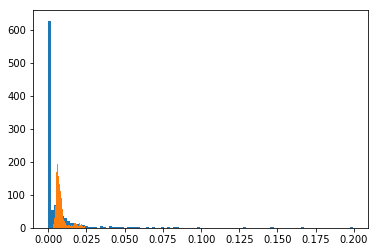

In [207]:
import matplotlib.pyplot as plt
plt.hist(real_values_fish[:1000, 6], bins=100)
plt.hist(imputed[:, 6], bins=100)



In [ ]:
plot_correlation(real_values_fish, proximity_imputed_values_fish)
plot_correlation(real_values_fish, normed_expected_frequencies_fish[:, 3])

In [ ]:
print(compute_metrics(real_values_fish, proximity_imputed_values_fish))
print(compute_metrics(real_values_fish, normed_expected_frequencies_fish[:, idx_to_impute]))

In [52]:
def is_good(array):
    for value in array:
        if value is True:
            return False
    return True
PCA_latent_fish = PCA_latent_fish.astype(np.float64)
to_keep = [i for i in range(PCA_normed_expected_frequencies_seq.shape[0]) if is_good(np.isnan(PCA_normed_expected_frequencies_seq[i, :])) and is_good(np.isinf(PCA_normed_expected_frequencies_seq[i, :]))]
PCA_normed_expected_frequencies_seq = PCA_values_seq / (np.sum(PCA_values_seq[:, :vae.n_input_fish],
                                                                    axis=1)+PCA_values_seq[:, idx_to_impute]).reshape(-1, 1)
PCA_normed_expected_frequencies_seq = PCA_normed_expected_frequencies_seq.astype(np.float64)
PCA_proximity_imputed_values_fish = proximity_imputation(PCA_latent_seq[to_keep, :], PCA_normed_expected_frequencies_seq[to_keep, idx_to_impute], PCA_latent_fish)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

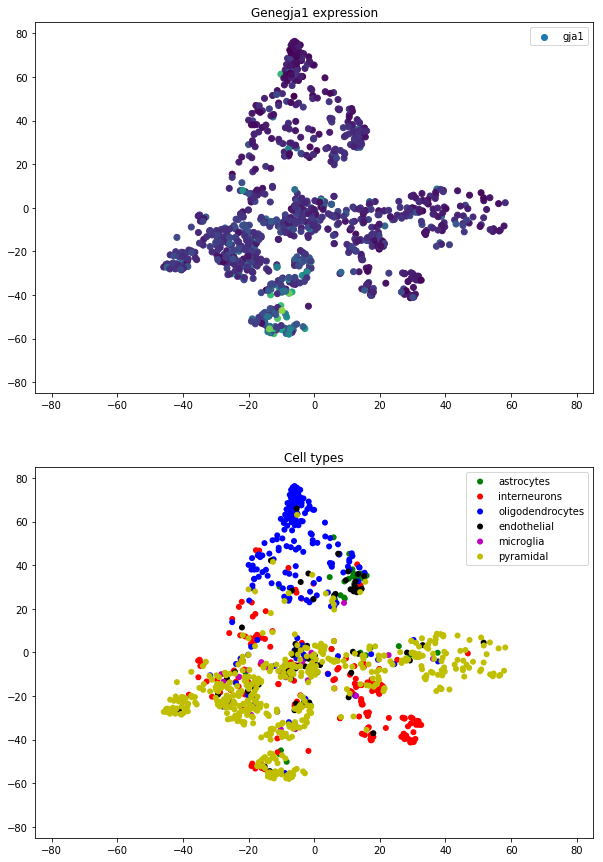

<Figure size 432x288 with 0 Axes>

In [18]:
show_gene_exp(t_sne_fish, normed_expected_frequencies_fish[idx_t_sne_fish, idx_astro], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_astro.svg", gene_name="gja1")

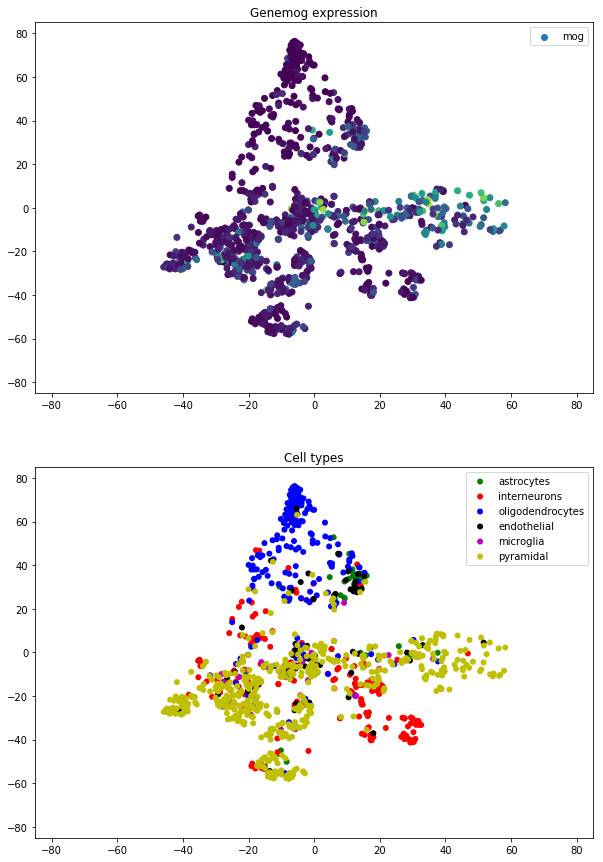

<Figure size 432x288 with 0 Axes>

In [19]:
show_gene_exp(t_sne_fish, normed_expected_frequencies_fish[idx_t_sne_fish, idx_oligo], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_oligo.svg", gene_name="mog")

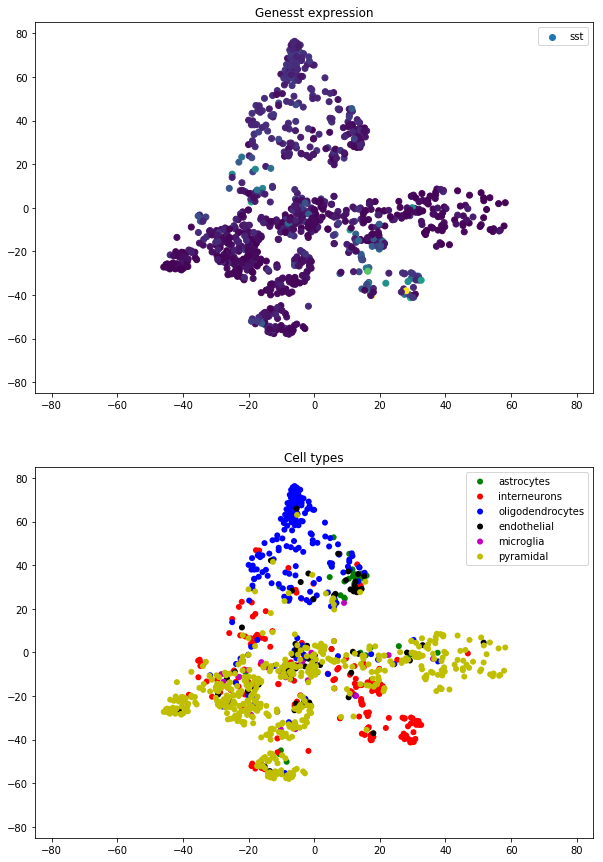

<Figure size 432x288 with 0 Axes>

In [21]:
show_gene_exp(t_sne_fish, normed_expected_frequencies_fish[idx_t_sne_fish, idx_interneurons], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_interneurons.svg", gene_name="sst")

In [ ]:
show_spatial_expression(x_coords[idx_t_sne_fish], y_coords[idx_t_sne_fish],
                        normed_expected_frequencies_fish[idx_t_sne_fish, idx_astro], labels=labels_fish[idx_t_sne_fish],
                        title="spatial_exp_astro.svg", gene_name="gja1")

In [ ]:
show_spatial_expression(x_coords[idx_t_sne_fish], y_coords[idx_t_sne_fish],
                        normed_expected_frequencies_fish[idx_t_sne_fish, idx_oligo], labels=labels_fish[idx_t_sne_fish],
                        title="spatial_exp_oligo.svg", gene_name="mog")

In [ ]:
show_spatial_expression(x_coords[idx_t_sne_fish], y_coords[idx_t_sne_fish],
                        normed_expected_frequencies_fish[idx_t_sne_fish, idx_interneurons],
                        labels=labels_fish[idx_t_sne_fish], title="spatial_exp_interneurons.svg", gene_name="sst")